In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
import json
import random
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import LSTM, Conv2D,BatchNormalization, MaxPooling2D, Dense, Activation, Reshape, Dropout, TimeDistributed
from keras.layers import Dense, Conv2D, Flatten
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras import optimizers
from keras.models import load_model

In [0]:
model_config = {
    'cnnlstm':{
        'batch_size' : 64,
        'num_classes' : 4,
        'num_epochs' : 300,
        'padding_mode' : 'same', #same, constant
        'padding_size' : 1000,
        'subseq_size' : 10,
        'lstm_cells' : 26,
        'learning_rate_min' : 0.000001,
        'learning_rate_max' : 0.001,
        'model_name': 'Audio_same1000_26_cnnlstm_2L2L_SGD_e300.h5'
    }
}

config = model_config['cnnlstm']

In [0]:
#@title Dataloader
#@markdown create a dataloader do import the input data and export the predictions

class KerasDataloader():
    """
    Keras Dataloader
    The data must be a json file with the following structure:
    { "0" : {"features" : [[]] ,
            "activation" : 0|1 ,
            "valence" : 0|1},
      "1" : ...}
    }

    Parameters
    ------
    filepath : str
        path to the file location
    filename : str
        filename for the dataimport
    traindata: bool
        If True, the data will be split into train and test dataset with data and label lists.
        if False, just a datalist will be created
    """

    def __init__(self, filepath, filename, paddingsize, traindata=True):
        self.filepath = filepath
        self.filename = filename
        self.traindata = traindata
        self.padding_size = paddingsize
        self.lookup = { (0,0): [1.0,0.0,0.0,0.0],
                        (1,0): [0.0,1.0,0.0,0.0],
                        (0,1): [0.0,0.0,1.0,0.0],
                        (1,1): [0.0,0.0,0.0,1.0]
                      }
        self.data=[]
        self.__load__()

    def __load__(self):
        data = {}
        with open(self.filepath+self.filename) as jsonFile:
            data = json.load(jsonFile)
        for item in data:
            if self.traindata:
                self.data.append({'features': data[item]['features'], 
                                  'label': self.__onehot__(data[item]['valence'], data[item]['activation']) })
            else:
              self.data.append({'features': data[item]['features']})
    
    def __onehot__(self, valence, activation):
        return self.lookup[(valence, activation)]
        
    def __onehot_rev__(self, value):
        for label, onehot in self.lookup.items():
            if np.argmax(onehot) == np.argmax(value):
                return label[0], label[1]

    def __pad__(self, array, mode):
        topad = max(0,self.padding_size-array.shape[0])
        
        if mode == 'constant':
            kwargs = {'pad_width' : ((0,topad),(0,0)),
                      'mode' : 'constant',
                      'constant_values' : 0,
                    }
        if mode == 'same':
             kwargs = {'pad_width' : ((0,topad),(0,0)),
                      'mode' : 'wrap'
                    }
        return np.pad(array, **kwargs)[:self.padding_size:]

    def load_data(self, splitvalue=0.1):
        """
        Function to load the input dataset

        Parameters
        ----------
        splitvalue : float
            split value between 0 and 1. Represents the percentage of the test, train set ratio
          
        Return
        ------
        Tupel: Lists
            (x_train, y_train), (x_val, y_val)
        
        """
        if self.traindata: 
            random.shuffle(self.data)
        x_train = []
        y_train = []
        x_val = []
        y_val = []
        if self.traindata:
            splitindex = int(len(self.data)*(1-splitvalue))
            train_set, val_set = self.data[:splitindex], self.data[splitindex+1:]
            for item in train_set:
                item['features'] = self.__pad__(np.asarray(item['features']), config['padding_mode'])
                x_train.append(item['features'])
                y_train.append(item['label'])
            for item in val_set:
                item['features'] = self.__pad__(np.asarray(item['features']), config['padding_mode'])
                x_val.append(item['features'])
                y_val.append(item['label'])
            
        else:
            for item in self.data:
                item['features'] = self.__pad__(np.asarray(item['features']), config['padding_mode'])
                x_train.append(item['features'])
        x_train=np.asarray(x_train)
        y_train=np.asarray(y_train)
        x_val=np.asarray(x_val)
        y_val=np.asarray(y_val)
        return (x_train, y_train), (x_val, y_val)

    def save_predictions(self, predictions):
        """
        Function to save the model prediction in json file with structure:
        { "0" : {"features" : [[]]},
          "1" : ...}
        }  
    
        Parameters
        ----------
        prediction : list
            a list of the predicted classes
          
        """
        result = {}
        for idx, prediction in enumerate(predictions):
            valence, activation = self.__onehot_rev__(prediction)
            result[str(idx)] = {'valence' : valence, 'activation': activation}
        with open(self.filepath + 'results.json', 'w') as fp:
            json.dump(result, fp)


In [69]:
# load data
dataloader = KerasDataloader('./gdrive/My Drive/develop/uni/deepl_project/data/','train.json',config['padding_size'])
(x_train, y_train), (x_val, y_val) = dataloader.load_data()

# restructure data (batch_size, count of subsequences, subsequence size, features, channels)
subseq_size = config['subseq_size']
x_train=x_train.reshape((x_train.shape[0], int(config['padding_size']/subseq_size), subseq_size, x_train.shape[2]))
x_val=x_val.reshape((x_val.shape[0], int(config['padding_size']/subseq_size), subseq_size, x_val.shape[2]))
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3],1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], x_val.shape[2], x_val.shape[3],1))

# Set the shapes
target_shape_train = y_train.shape
target_shape_test = y_val.shape 
input_shape_total = x_train.shape
input_shape = x_train.shape[1:]

# print the shapes
print(target_shape_train)
print(target_shape_test)
print(input_shape_total)
print(input_shape)


(7020, 4)
(779, 4)
(7020, 100, 10, 26, 1)
(100, 10, 26, 1)


In [0]:
class CNNLSTMClassifier():
    def __init__(self):
        cnn = Sequential(name=config['model_name'])
        cnn.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last'))
        cnn.add(BatchNormalization())
        cnn.add(Activation('elu'))
        cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        cnn.add(Dropout(0.5))

        cnn.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'))
        cnn.add(BatchNormalization())
        cnn.add(Activation('elu'))
        cnn.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
        cnn.add(Dropout(0.25))

        cnn.add(Flatten())

        #prepare stacked LSTM
        model = Sequential(name=config['model_name'])
        model.add(TimeDistributed(cnn,input_shape=input_shape))
        model.add(LSTM(config['lstm_cells'],return_sequences=True))
        model.add(LSTM(config['lstm_cells'],return_sequences=True))

        model.add(Flatten())
        model.add(Dense(config['num_classes'],activation='softmax')) 

        # Model compilation
        #opt = optimizers.Adam(lr=0.001, beta_1=0.9,  beta_2=0.999, amsgrad=False)
        opt = optimizers.SGD(lr=config['learning_rate_max'], momentum=0.9, nesterov=False)
        model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        self.model = model

    def load(self):
        return self.model


In [71]:
# load model
model = CNNLSTMClassifier().load()

# Summary
model.summary()

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
# Name format datatype_sequencelength_featurelength_architecture_layercount_epochs_accuracy:
mcp_save = ModelCheckpoint('./gdrive/My Drive/develop/uni/deepl_project/runs/models/'+ config['model_name'], 
                           save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(x_train, y_train, batch_size=config['batch_size'], epochs=config['num_epochs'],
                     validation_data=(x_val, y_val), callbacks=[mcp_save, lr_reduce])


Model: "Audio_same1000_26_cnnlstm_2L2L_SGD_e300.h5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_5 (TimeDist (None, 100, 384)          19488     
_________________________________________________________________
lstm_9 (LSTM)                (None, 100, 26)           42744     
_________________________________________________________________
lstm_10 (LSTM)               (None, 100, 26)           5512      
_________________________________________________________________
flatten_10 (Flatten)         (None, 2600)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 10404     
Total params: 78,148
Trainable params: 77,956
Non-trainable params: 192
_________________________________________________________________
Train on 7020 samples, validate on 779 samples
Epoch 1/300
7020/7020 [==============

KeyboardInterrupt: ignored

In [72]:
max(cnnhistory.history['val_categorical_accuracy'])

0.5892169451835985

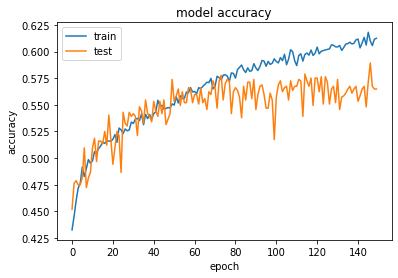

In [74]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['categorical_accuracy'])
plt.plot(cnnhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

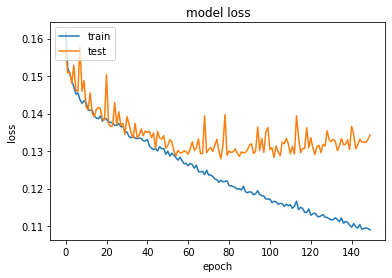

In [76]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
#model = load_model('./gdrive/My Drive/develop/uni/deepl_project/runs/models/Audio_same500_26_cnnlstm_2L1L_SGD_e300.h5')

In [0]:
#model.evaluate(x_val, y_val, verbose = 0)

[0.8207830921370196, 0.6752246472128549]

In [0]:
dataloader_dev = KerasDataloader('./gdrive/My Drive/develop/uni/deepl_project/data/',
                                 'dev.json', config['padding_size'], traindata=False)
(x_dev, y_train), (x_val, y_val) = dataloader_dev.load_data()
x_dev=x_dev.reshape((x_dev.shape[0], int(config['padding_size']/subseq_size), subseq_size, x_dev.shape[2]))
x_dev = x_dev.reshape((x_dev.shape[0], x_dev.shape[1], x_dev.shape[2],x_dev.shape[3], 1))

predictions = model.predict(x_dev)
print(predictions.shape)

(3342, 4)


In [0]:
dataloader_dev.save_predictions(predictions)